In this notebook, we are creating a simple 3d cnn model using cats and dog image. The model has to classify the images. To make it 3d we stacked up 10 images of each class together and took it as a volume. So the basic dimension is 10X128X128X3. 10 is the no. of images, 128x128 is the height and width of the image, 3 is the number of channels. The images are converted into numpy arrays then split into test, train and validation. After that they are converted to tensors.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

#Loading the numpy files from the drive

X_train = np.load('/content/drive/MyDrive/Colab Notebooks/cats_dogs/X_train.npy')
y_train = np.load('/content/drive/MyDrive/Colab Notebooks/cats_dogs/y_train.npy')
X_val = np.load('/content/drive/MyDrive/Colab Notebooks/cats_dogs/X_val.npy')
y_val = np.load('/content/drive/MyDrive/Colab Notebooks/cats_dogs/y_val.npy')
X_test = np.load('/content/drive/MyDrive/Colab Notebooks/cats_dogs/X_test.npy')
y_test = np.load('/content/drive/MyDrive/Colab Notebooks/cats_dogs/y_test.npy')

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(1588, 10, 128, 128, 3)
(1588, 1, 2)
(397, 10, 128, 128, 3)
(397, 1, 2)
(497, 10, 128, 128, 3)
(497, 1, 2)


In [ ]:
import torch

# Example: Assume you have already loaded your numpy arrays
# X_train, X_test, X_val should be numpy arrays of shape (samples, 10, 128, 128, 3)

# Reshape the X arrays to (samples, channels, depth, height, width)
X_train_reshaped = torch.from_numpy(X_train).permute(0, 4, 1, 2, 3).float()  # Shape: (1588, 3, 10, 128, 128)
X_test_reshaped = torch.from_numpy(X_test).permute(0, 4, 1, 2, 3).float()    # Shape: (397, 3, 10, 128, 128)
X_val_reshaped = torch.from_numpy(X_val).permute(0, 4, 1, 2, 3).float()      # Shape: (497, 3, 10, 128, 128)

# Now X_train_reshaped, X_test_reshaped, and X_val_reshaped are ready for use in your 3D CNN model
print(X_train_reshaped.shape)
print(X_test_reshaped.shape)
print(X_val_reshaped.shape)

torch.Size([1588, 3, 10, 128, 128])
torch.Size([497, 3, 10, 128, 128])
torch.Size([397, 3, 10, 128, 128])


In [ ]:
import torch

# Assuming y_train, y_test, y_val are numpy arrays already loaded

# Convert to tensors
y_train_tensor = torch.from_numpy(y_train).float()  # Shape: (1588, 1, 2)
y_test_tensor = torch.from_numpy(y_test).float()    # Shape: (397, 1, 2)
y_val_tensor = torch.from_numpy(y_val).float()      # Shape: (497, 1, 2)

# Remove the extra dimension using squeeze
y_train_reshaped = y_train_tensor.squeeze(1)  # Shape: (1588, 2)
y_test_reshaped = y_test_tensor.squeeze(1)    # Shape: (397, 2)
y_val_reshaped = y_val_tensor.squeeze(1)      # Shape: (497, 2)

# Now y_train_reshaped, y_test_reshaped, and y_val_reshaped are ready for use
print(y_train_reshaped.shape)
print(y_test_reshaped.shape)
print(y_val_reshaped.shape)

torch.Size([1588, 2])
torch.Size([497, 2])
torch.Size([397, 2])


Now, numpy arrays are converted into tensors and they look like this
X_train_reshaped = torch.from_numpy(X_train).permute(0, 4, 1, 2, 3).float()  # Shape: (1588, 3, 10, 128, 128)
X_test_reshaped = torch.from_numpy(X_test).permute(0, 4, 1, 2, 3).float()    # Shape: (397, 3, 10, 128, 128)
X_val_reshaped = torch.from_numpy(X_val).permute(0, 4, 1, 2, 3).float()      # Shape: (497, 3, 10, 128, 128)
y_train_tensor = torch.from_numpy(y_train).float()  # Shape: (1588, 1, 2)
y_test_tensor = torch.from_numpy(y_test).float()    # Shape: (397, 1, 2)
y_val_tensor = torch.from_numpy(y_val).float()      # Shape: (497, 1, 2)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
# Create TensorDatasets
train_dataset = TensorDataset(X_train_reshaped, y_train_tensor)
val_dataset = TensorDataset(X_val_reshaped, y_val_tensor)
test_dataset = TensorDataset(X_test_reshaped, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for data, labels in train_loader:
    print(data.shape)
    print(labels.shape)
    break

# You can access the shapes of the datasets themselves
print(train_dataset.tensors[0].shape) # shape of X_train_reshaped
print(train_dataset.tensors[1].shape)

torch.Size([32, 3, 10, 128, 128])
torch.Size([32, 1, 2])
torch.Size([1588, 3, 10, 128, 128])
torch.Size([1588, 1, 2])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
#class that inherits from the nn.module that will define the cnn architecture
class Simple3DCNN(nn.Module):
    def __init__(self):
        super(Simple3DCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv3d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 1 * 16 * 16, 128)  # Adjust based on output size from convolutions
        self.fc2 = nn.Linear(128, 2)  # Output layer for binary classification

        # Activation and pooling layers
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

    def forward(self, x):
        # Forward pass through the network
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # Output layer

        return x


In [ ]:

#Instantiate the model
model = Simple3DCNN()
#model = model.cuda()
for name, module in model.named_children():
    print(name, module)
print(model)



conv1 Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
conv2 Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
conv3 Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
fc1 Linear(in_features=16384, out_features=128, bias=True)
fc2 Linear(in_features=128, out_features=2, bias=True)
relu ReLU()
pool MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Simple3DCNN(
  (conv1): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # This is equivalent to model.cuda()


In [ ]:
#Define Loss and optimizer
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [ ]:
import matplotlib.pyplot as plt
# Initialize lists for training, validation accuracies, and their gaps
num_epochs = 20
train_accuracies = []
val_accuracies = []
accuracy_gaps = []  # List to store gaps between training and validation accuracies

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Training loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradients

        outputs = model(inputs)  # Forward pass
        labels = labels.squeeze(1)  # Remove the extra dimension
        labels = torch.argmax(labels, dim=1)  # Convert from one-hot to class indices
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate and store training accuracy
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            labels = labels.squeeze(1)
            labels = torch.argmax(labels, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate and store validation accuracy
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Calculate and store the accuracy gap
    accuracy_gap = abs(train_accuracy - val_accuracy)
    accuracy_gaps.append(accuracy_gap)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, '
          f'Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%, '
          f'Accuracy Gap: {accuracy_gap:.2f}%')


Epoch [1/20], Loss: 2.2515, Training Accuracy: 50.50%, Validation Accuracy: 53.15%, Accuracy Gap: 2.64%
Epoch [2/20], Loss: 0.6906, Training Accuracy: 51.32%, Validation Accuracy: 55.42%, Accuracy Gap: 4.09%
Epoch [3/20], Loss: 0.6813, Training Accuracy: 58.12%, Validation Accuracy: 56.17%, Accuracy Gap: 1.95%
Epoch [4/20], Loss: 0.6592, Training Accuracy: 63.16%, Validation Accuracy: 62.72%, Accuracy Gap: 0.44%
Epoch [5/20], Loss: 0.6516, Training Accuracy: 60.33%, Validation Accuracy: 53.15%, Accuracy Gap: 7.18%
Epoch [6/20], Loss: 0.6169, Training Accuracy: 67.00%, Validation Accuracy: 66.75%, Accuracy Gap: 0.25%
Epoch [7/20], Loss: 0.5387, Training Accuracy: 72.67%, Validation Accuracy: 67.00%, Accuracy Gap: 5.67%
Epoch [8/20], Loss: 0.4663, Training Accuracy: 78.65%, Validation Accuracy: 72.04%, Accuracy Gap: 6.61%
Epoch [9/20], Loss: 0.4054, Training Accuracy: 82.18%, Validation Accuracy: 80.35%, Accuracy Gap: 1.83%
Epoch [10/20], Loss: 0.3348, Training Accuracy: 87.41%, Validati

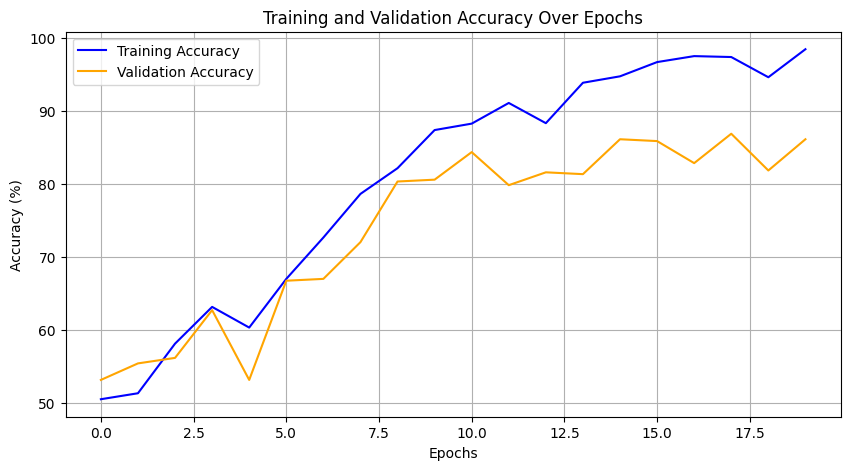

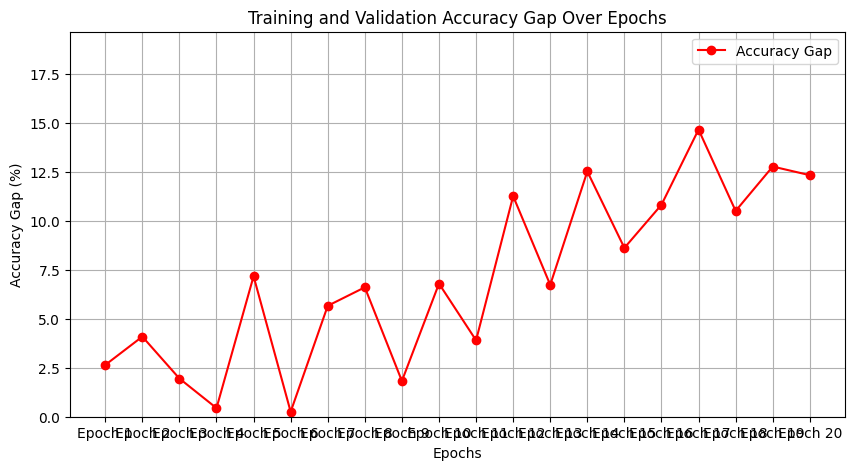

In [ ]:
# After training, plot both accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()
# After training, plot the accuracy gaps
plt.figure(figsize=(10, 5))
plt.plot(accuracy_gaps, label='Accuracy Gap', color='red', marker='o')  # Add markers for clarity
plt.title('Training and Validation Accuracy Gap Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Gap (%)')
plt.xticks(ticks=range(num_epochs), labels=[f'Epoch {i+1}' for i in range(num_epochs)])  # Set x-ticks
plt.legend()
plt.grid()
plt.ylim(0, max(accuracy_gaps) + 5)  # Set y-axis limit to visualize gaps better
plt.show()


In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    correct = 0
    total = 0

    for inputs, labels in test_loader:  # Iterate over the test data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)  # Forward pass

        # Ensure labels are in the correct shape
        labels = labels.squeeze(1)  # Remove the extra dimension if needed
        labels = torch.argmax(labels, dim=1)  # Convert from one-hot to class indices

        _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability

        total += labels.size(0)  # Update the total number of samples
        correct += (predicted == labels).sum().item()  # Update the number of correct predictions

    print(f'Test Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 86.12%


In [ ]:
import torch
from torchvision import transforms
import numpy as np
import cv2  # OpenCV for image processing

# Function to resize a volume to a new shape

def resize_volume(volume, new_shape):
    # Ensure new_shape is (D, H, W, C) format
    resized_volume = np.empty((new_shape[0], new_shape[1], new_shape[2], volume.shape[3]))

    for i in range(volume.shape[0]):  # Loop through each slice
        # Resize each 2D slice while preserving the number of channels
        resized_volume[i] = cv2.resize(volume[i], (new_shape[2], new_shape[1]))  # Resize H, W
    return resized_volume

# Update your load_volume function
def load_volume(file_path):
    volume = np.load(file_path)  # Load your volume (10, 128, 128, 3)
    volume = resize_volume(volume, (10, 128, 128))  # Resize if necessary

    # Rearrange dimensions to (C, D, H, W) -> (3, 10, 128, 128)
    volume = torch.tensor(volume).permute(3, 0, 1, 2)  # Change shape to (3, 10, 128, 128)

    volume = volume.float()  # Convert to float if necessary
    volume = volume.unsqueeze(0)  # Add batch dimension, shape now: (1, 3, 10, 128, 128)
    return volume
# Define your transformation without resizing
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])




# Specify the paths for the single volumes you want to test
cat_volume_path = '/content/drive/MyDrive/Colab Notebooks/cats_dogs/volume_0044.npy'  # Update with the correct path
dog_volume_path = '/content/drive/MyDrive/Colab Notebooks/cats_dogs/volume_0033.npy'  # Update with the correct path

# Load and preprocess the specific volumes
cat_volume = load_volume(cat_volume_path)
dog_volume = load_volume(dog_volume_path)

# Set the model to evaluation mode
model.eval()
def predict(volume):
    with torch.no_grad():
        volume = volume.to(device)
        output = model(volume)
        probabilities = torch.softmax(output, dim=1)  # Convert logits to probabilities
        _, predicted = torch.max(probabilities, 1)  # Get the predicted class
        confidence = probabilities[0][predicted].item() * 100  # Get the confidence percentage
        return predicted.item(), confidence


# Make predictions for the specified volumes
cat_prediction, cat_confidence = predict(cat_volume)
dog_prediction, dog_confidence = predict(dog_volume)

# Mapping predicted indices to class names
class_names = ['Cat', 'Dog']

print(f'Cat volume prediction: {class_names[cat_prediction]}, Confidence: {cat_confidence:.2f}%')
print(f'Dog volume prediction: {class_names[dog_prediction]}, Confidence: {dog_confidence:.2f}%')


Cat volume prediction: Cat, Confidence: 99.83%
Dog volume prediction: Dog, Confidence: 93.71%


In [ ]:
# Implementing Grad-Cam for this model

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.features = None

        # Hook the forward and backward functions
        self.target_layer.register_forward_hook(self.save_features)
        self.target_layer.register_backward_hook(self.save_gradients)

    def save_features(self, module, input, output):
        self.features = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]  # Gradients of the output with respect to the input

    def generate(self, input_tensor, target_class):
    # Forward pass
      self.model(input_tensor)

    # Backward pass
      self.model.zero_grad()
      target = self.model(input_tensor)
      loss = target[0, target_class]  # Select the output for the target class
      loss.backward()

    # Generate heatmap
      weights = self.gradients.mean(dim=(2, 3, 4), keepdim=True)  # Average gradients
      heatmap = (weights * self.features).sum(dim=1, keepdim=True)  # Weighted sum of features
      heatmap = F.relu(heatmap)  # Apply ReLU
      #heatmap = heatmap.squeeze()  # Remove extra dimensions

    # Resize heatmap to match input spatial dimensions
      heatmap = F.interpolate(heatmap, size=input_tensor.shape[2:], mode='trilinear', align_corners=False)
      heatmap = heatmap.squeeze().cpu().detach().numpy()  # Convert to numpy for visualization

    # Normalize the heatmap
      heatmap -= heatmap.min()
      heatmap /= heatmap.max()
      return heatmap


In [ ]:
# Step 1: Define a variable to store the output of conv2
conv2_output = None

# Step 2: Create a hook function to capture the output
def get_conv2_output(module, input, output):
    global conv2_output
    conv2_output = output  # Save the output of conv2 layer

# Step 3: Register the hook on the target layer
hook = model.conv2.register_forward_hook(get_conv2_output)

# Step 4: Load your volumes and preprocess as necessary
cat_volume = load_volume(cat_volume_path)  # Load cat volume
print(cat_volume.shape)
cat_volume = cat_volume.squeeze(0)
print(cat_volume.shape)
input_tensor = cat_volume.permute(0, 2, 3, 1).unsqueeze(0).cuda()  # Adjust dimensions

# Step 5: Run forward pass to get conv2_output
with torch.no_grad():
    model(input_tensor)  # Forward pass

# Step 6: Print shapes for comparison
print("Input Tensor Shape:", input_tensor.shape)  # Shape of input tensor
print("Output Shape from conv2 Layer:", conv2_output.shape)  # Shape of target layer output

# Step 7: Clean up (remove the hook)
hook.remove()


torch.Size([1, 3, 10, 128, 128])
torch.Size([3, 10, 128, 128])
Input Tensor Shape: torch.Size([1, 3, 128, 128, 10])
Output Shape from conv2 Layer: torch.Size([1, 32, 64, 64, 5])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


<class 'numpy.ndarray'>


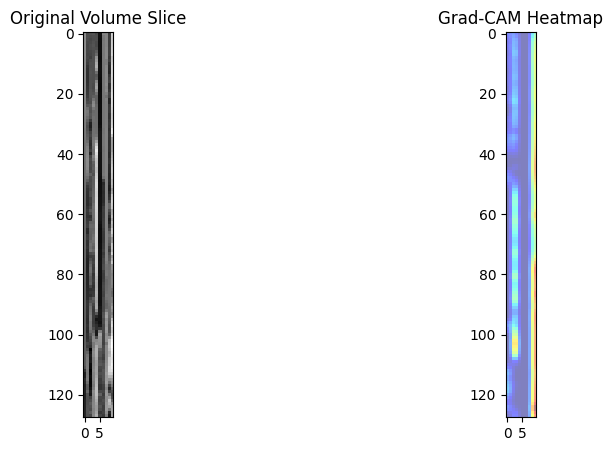

(128, 128, 10)
(1, 3, 128, 128, 10)


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Assuming your GradCAM class is defined above this section

# Step 1: Create the model instance and GradCAM instance
model = Simple3DCNN()  # Your model
model.cuda()  # Move to GPU if available

# Step 2: Load your volumes
#cat_volume = load_volume(cat_volume_path)  # Load cat volume
#dog_volume = load_volume(dog_volume_path)  # Load dog volume

# Process cat volume for prediction
#cat_volume = cat_volume.squeeze(0)  # Remove batch dimension

#input_tensor = cat_volume.permute(0, 2, 3, 1).unsqueeze(0).cuda()  # Shape: [1, 3, 10, 128, 128]

# Step 3: Create Grad-CAM instance, specifying the target layer
grad_cam = GradCAM(model, model.conv2)  # Pass the conv2 layer as the target layer

# Step 4: Run forward pass and generate heatmap
with torch.no_grad():  # No need to track gradients for Grad-CAM
    model(input_tensor)  # Forward pass to get output

# Step 5: Generate Grad-CAM heatmap
target_class = 0  # For cat class (assuming 0 is cat, 1 is dog)
heatmap = grad_cam.generate(input_tensor, target_class)
print(type(heatmap))

# Step 6: Visualize the heatmap
def visualize_heatmap(heatmap, original_volume):
    plt.figure(figsize=(10, 5))

    # Show one slice from the original volume
    slice_index = 0  # Choose a slice index to visualize (0-9 for 10 slices)
    channel_index = 0  # Choose a channel to visualize (0-2 for 3 channels)

    plt.subplot(1, 2, 1)
    plt.title("Original Volume Slice")
    plt.imshow(original_volume[0, channel_index, :, slice_index], cmap='gray')  # Show the specified channel and slice

    # Show heatmap
    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap[0, :, :], cmap='jet', alpha=0.5)  # Show heatmap with alpha blending

    plt.show()

# Convert the input tensor to numpy for visualization
original_volume_np = input_tensor.cpu().detach().numpy()

# Call the visualization function
visualize_heatmap(heatmap, original_volume_np)
print(heatmap.shape)
print(original_volume_np.shape)

# Step 7: Clean up (remove the hook)
# Assuming you stored the hook when you registered it, you can remove it here.


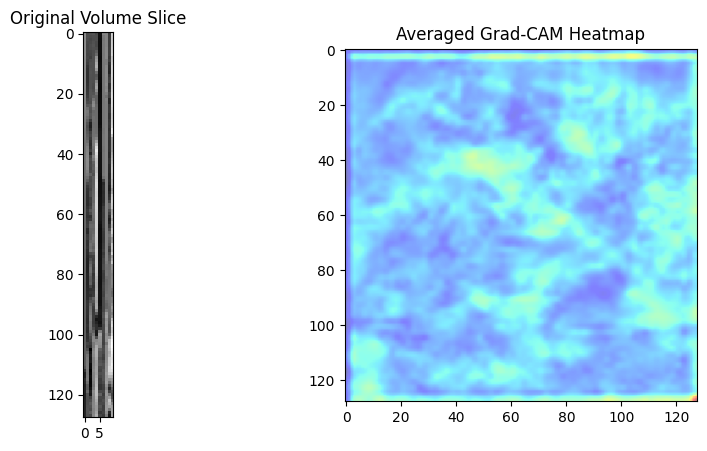

In [ ]:
# Assuming heatmap is already defined and has shape (128, 128, 10)

# Step 1: Average across the last dimension to get a 2D heatmap
heatmap_2d = heatmap.mean(axis=-1)  # Resulting shape: (128, 128)

# Step 2: Normalize the heatmap
heatmap_2d -= heatmap_2d.min()
heatmap_2d /= heatmap_2d.max()

# Step 3: Visualize the averaged heatmap alongside the original volume slice
def visualize_average_heatmap(heatmap_2d, original_volume):
    slice_index = 0  # Choose a slice index to visualize (0-9 for 10 slices)
    channel_index = 0  # Choose a channel to visualize (0-2 for 3 channels)
    plt.figure(figsize=(10, 5))

    # Show one slice from the original volume
    plt.subplot(1, 2, 1)
    plt.title("Original Volume Slice")
    plt.imshow(original_volume[0, channel_index, :, slice_index], cmap='gray')  # Show the specified channel and slice

    # Show the averaged heatmap
    plt.subplot(1, 2, 2)
    plt.title("Averaged Grad-CAM Heatmap")
    plt.imshow(heatmap_2d, cmap='jet', alpha=0.5)  # Show heatmap with alpha blending

    plt.show()

# Call the visualization function
visualize_average_heatmap(heatmap_2d, original_volume_np)


torch.Size([1, 3, 10, 128, 128])
(3, 128, 128)


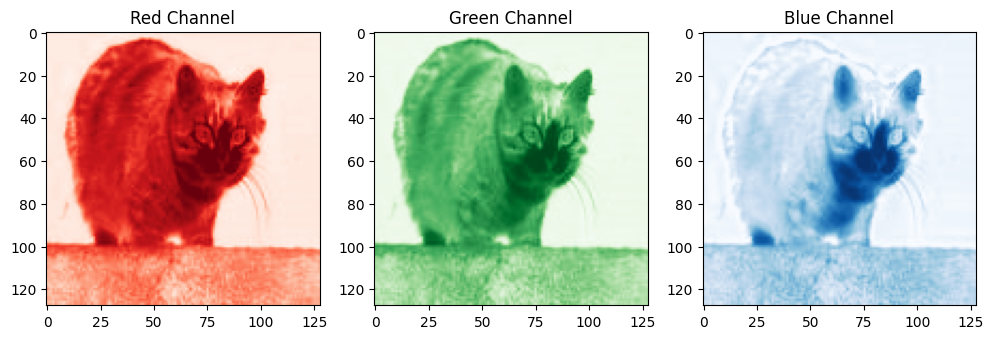

(128, 128, 10)


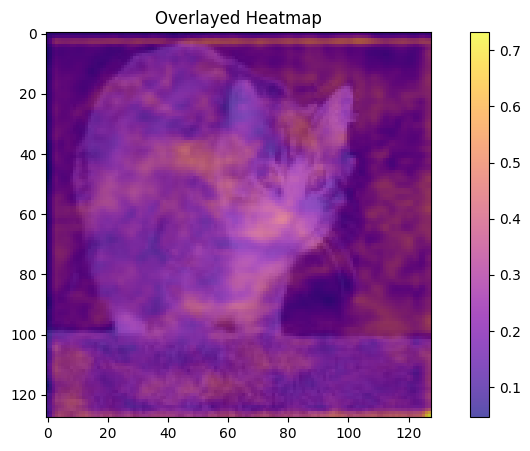

In [ ]:
import matplotlib.pyplot as plt
import cv2  # Ensure you have OpenCV installed

# Load your real volume (assumed to be already loaded as a NumPy array)
# Example: real_volume = load_volume(real_volume_path)
real_volume = load_volume(cat_volume_path)
print(real_volume.shape)
# Select a slice from the real volume
slice_index = 5  # Choose an index based on your volume
real_image_slice = real_volume[0, :, slice_index, :, :]  # Shape: (3, 128, 128)

# Convert the real image slice to a format suitable for displaying
real_image_slice = real_image_slice.cpu().detach().numpy()
print(real_image_slice.shape)
# Resize the heatmap to match the real image slice dimensions
import matplotlib.pyplot as plt

# Choose a specific slice index
slice_index = 5
real_image_slice = real_volume[0, :, slice_index, :, :]

# Convert to numpy for visualization (if using PyTorch tensors)
real_image_slice_np = real_image_slice.cpu().detach().numpy()  # Convert to numpy array

# Plotting the RGB channels
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Red Channel")
plt.imshow(real_image_slice_np[0, :, :], cmap='Reds')  # Display Red channel

plt.subplot(1, 3, 2)
plt.title("Green Channel")
plt.imshow(real_image_slice_np[1, :, :], cmap='Greens')  # Display Green channel

plt.subplot(1, 3, 3)
plt.title("Blue Channel")
plt.imshow(real_image_slice_np[2, :, :], cmap='Blues')  # Display Blue channel

plt.show()

heatmap_resized = cv2.resize(heatmap, (128, 128))  # Make sure to import cv2
print(heatmap_resized.shape)

import numpy as np

# Assuming heatmap is a numpy array with shape (128, 128, 10)
heatmap_average = np.mean(heatmap, axis=2)  # Shape will now be (128, 128)
slice_index = 5  # For example, select the 6th slice
heatmap_slice = heatmap[:, :, slice_index]  # Shape will be (128, 128)
# Assuming you have already selected a real image slice
real_image_slice = real_volume[0, :, slice_index, :, :].cpu().detach().numpy()  # Shape: (3, 128, 128)

# Convert to RGB by selecting a specific channel or averaging
real_image_slice_rgb = np.mean(real_image_slice, axis=0)  # Shape: (128, 128)

# Visualize the overlap
plt.figure(figsize=(10, 5))
plt.imshow(real_image_slice_rgb, cmap='gray', alpha=1)  # Show real image
plt.imshow(heatmap_average, cmap='plasma', alpha=0.7)  # Overlay heatmap
plt.title("Overlayed Heatmap")
plt.colorbar()  # Optional: to show color scale
plt.show()

